In [129]:
import calitp
from calitp.tables import tbl
from siuba import *

import pandas as pd
import numpy as np

import geopandas as gpd
import seaborn as sns

from ipyleaflet import Map, GeoJSON, projections, basemaps, GeoData, LayersControl, WidgetControl, GeoJSON
from ipywidgets import Text, HTML

## About how many validators are needed to connect to LOSSAN?

### Set up views

In [2]:
transit_stacks = tbl.views.transitstacks()

In [3]:
lossan_counties = ['San Luis Obispo', 'Santa Barbara', 'Ventura',
                  'Los Angeles', 'San Diego']

In [4]:
dim_stops = (tbl.views.gtfs_schedule_dim_stops()
                 >> select(_.itp_id == _.calitp_itp_id, _.stop_key, _.stop_id, _.stop_lat, _.stop_lon, _.stop_name)
                )

In [5]:
dim_routes = (tbl.views.gtfs_schedule_dim_routes()
                 >> select(_.itp_id == _.calitp_itp_id, _.route_key, _.route_type)
                )

In [6]:
weekday_rail_stops = (tbl.views.gtfs_schedule_fact_daily_feed_routes()
                    >> filter(_.date == '2021-09-01') #weekday service (Wed)
                    >> select(_.route_key, _.date)
                    >> inner_join(_, dim_routes, on='route_key')
                    >> filter(_.route_type != '3') #not bus stops
                    >> inner_join(_, tbl.views.gtfs_schedule_index_feed_trip_stops(), on='route_key')
                    >> collect()
                    >> distinct(_.stop_key, _keep_all = True) #have to collect first to keep all, slow
                    >> group_by(_.itp_id)
                    >> count(_.route_type)
                      )

In [7]:
weekday_stops = (tbl.views.gtfs_schedule_fact_daily_feed_stops()
                    >> filter(_.date == '2021-09-01') #weekday service (Wed)
                    >> select(_.stop_key, _.date)
                    >> inner_join(_, dim_stops, on='stop_key')
                      )

In [8]:
info_cols = ['itp_id', 'transit_provider', 'ntd_id',
             'modes', 'county', 'legacy_ntd_id']

vehicle_cols = ['bus', 'articulated_bus', 'over_the_road_bus',
                'school_bus', 'trolleybus', 'vintage_historic_trolley',
                'streetcar']

paratransit_cols = ['van', 'cutaway', 'automobile',
                     'minivan', 'sport_utility_vehicle']

In [50]:
lossan_county_stops = (transit_stacks
                         >> filter(_.county.isin(lossan_counties))
                         >> select(_.itp_id, _.transit_provider, _.upt_total_2019)
                         >> inner_join(_, weekday_stops, on = "itp_id")
                         >> collect()
                    )

In [51]:
lossan_operators = (transit_stacks
                         >> filter(_.county.isin(lossan_counties))
                         >> select(*(info_cols + vehicle_cols + paratransit_cols))
                         >> collect()
                    )

In [52]:
lossan_operators.replace(' ', np.nan, inplace=True)
for col in (vehicle_cols + paratransit_cols):
    lossan_operators = lossan_operators.astype({col:'float64'})

In [53]:
lossan_connecting_rail_stops = (transit_stacks
                         >> filter(_.county.isin(lossan_counties))
                         >> select(*info_cols)
                         >> collect()
                         >> inner_join(_, weekday_rail_stops, on='itp_id')
                         >> rename(rail_stop_count = _.n)
                               )

### Estimate validators required per vehicle/stop

In [54]:
## Eric's estimation...
validators_needed = pd.Series({'bus': 2, 'articulated_bus': 3, 'over_the_road_bus': 1,
                             'vintage_historic_trolley': 2, 'trolleybus': 2, 'streetcar': 2,
                             'van': 1, 'cutaway': 1, 'automobile': 1,
                             'minivan': 1, 'sport_utility_vehicle': 1, 'school_bus': 1,
                              })

# 0: LRT, 1: HRT, 2: Commuter Rail, 4: Ferry (from GTFS routes.txt)
rail_validators_needed = pd.Series({'0': 6, '1': 10, '2': 6, '4': 4})

## Rail/Ferry

### Finding LOSSAN stations

In [55]:
## We don't quite have this (Amtrak) in data warehouse yet...
## from https://gis.data.ca.gov/datasets/63697b01616b4df68e2b316e73d7a4d6_0/
ca_rail = gpd.read_file('./California_Rail_Stations.geojson')

In [56]:
lossan_lines = ['Ventura County Line',
                'Burbank-Bob Hope Airport,Ventura County Line',
                '91 Line,Antelope Valley Line,Burbank-Bob Hope Airport,Orange County Line,Riverside Line,San Bernardino Line,Ventura County Line',
                'Antelope Valley Line,Burbank-Bob Hope Airport,Ventura County Line',
                'Orange County Line',
                '91 Line,Orange County Line',
                'Inland Empire-Orange County Line,Orange County Line',
                'Coaster,Inland Empire-Orange County Line,Orange County Line',
                'Coaster',
                ]

In [57]:
lossan_stations = ca_rail[ca_rail['PASS_NETWO'].str.contains('Surfliner')
                       | ca_rail['COMM_NETWO'].isin(lossan_lines)]

### Connecting rail/ferry transit

In [58]:
lossan_connecting_rail_stops['validator_count'] = lossan_connecting_rail_stops.apply(
                                lambda x: x.rail_stop_count * rail_validators_needed[x.route_type], axis=1)
lossan_connecting_rail_stops['is_paratransit'] = False
lossan_connecting_rail_stops['lossan_connection'] = True

## Direct LOSSAN Connections

### Find bus stops near LOSSAN stations

In [59]:
lossan_county_stops = gpd.GeoDataFrame(
                lossan_county_stops,
                geometry = gpd.points_from_xy(lossan_county_stops.stop_lon, lossan_county_stops.stop_lat),
                crs='EPSG:4326')

In [60]:
## project stations for buffer
lossan_stations = lossan_stations.to_crs('EPSG:6414') ## https://epsg.io/6414 (meters)
lossan_stations.geometry = lossan_stations.geometry.buffer(800) ## 800 meter buffer ~ .5mi

In [61]:
lossan_connect_stops = gpd.clip(lossan_county_stops.to_crs('EPSG:6414'), lossan_stations)

In [62]:
# lossan_stations.plot()

In [63]:
# lossan_county_stops.plot()

In [64]:
# lossan_connect_stops.plot()

In [65]:
lossan_connect_operators = (transit_stacks 
     >> filter(_.itp_id.isin(lossan_connect_stops.itp_id))
     >> select(*(info_cols + vehicle_cols + paratransit_cols))
     >> mutate(lossan_connection = True)
     >> collect()
    )

In [66]:
lossan_connect_operators.replace(' ', np.nan, inplace=True)
for col in (vehicle_cols + paratransit_cols):
    lossan_connect_operators = lossan_connect_operators.astype({col:'float64'})

In [67]:
non_connect_operators = (lossan_operators
                             >> filter(~_.itp_id.isin(lossan_connect_operators['itp_id']))
                             >> mutate(lossan_connection = False)
                        )

## Format for analysis

In [68]:
lossan_corridor_operators = lossan_connect_operators.append(non_connect_operators)

In [69]:
lossan_corridor_operators = (lossan_corridor_operators
                            .melt(id_vars=info_cols + ['lossan_connection'])
                            .rename(columns={'variable':'vehicle_type', 'value':'vehicle_count'}))

In [70]:
lossan_corridor_operators['validator_count'] = lossan_corridor_operators.apply(
                                            lambda x: x.vehicle_count * validators_needed[x.vehicle_type], axis=1)
lossan_corridor_operators['is_paratransit'] = lossan_corridor_operators['vehicle_type'].apply(
                                            lambda x: x in paratransit_cols)

lossan_corridor_operators = lossan_corridor_operators.append(lossan_connecting_rail_stops)

In [71]:
lossan_corridor_operators.head(3)

,itp_id,transit_provider,ntd_id,modes,county,legacy_ntd_id,lossan_connection,vehicle_type,vehicle_count,validator_count,is_paratransit,route_type,rail_stop_count
0,300,Big Blue Bus,90008,"DT,DR,MB",Los Angeles,9008,True,bus,167.0,334.0,False,NaN,NaN
1,339,Torrance Transit System,90010,"MB,DT",Los Angeles,9010,True,bus,63.0,126.0,False,NaN,NaN
2,293,Santa Barbara Metropolitan Transit District,90020,MB,Santa Barbara,9020,True,bus,114.0,228.0,False,NaN,NaN


In [72]:
lossan_corridor_operators.tail(2)

,itp_id,transit_provider,ntd_id,modes,county,legacy_ntd_id,lossan_connection,vehicle_type,vehicle_count,validator_count,is_paratransit,route_type,rail_stop_count
5,182,Los Angeles Metro,90154,"HR,RB,LR,MB,MB,VP",Los Angeles,9154,True,NaN,NaN,474.0,False,0,79.0
6,182,Los Angeles Metro,90154,"HR,RB,LR,MB,MB,VP",Los Angeles,9154,True,NaN,NaN,160.0,False,1,16.0


In [73]:
lossan_corridor_operators.groupby(['lossan_connection', 'is_paratransit'])[['validator_count']].sum()

validator_count
lossan_connection is_paratransit                 
False             False                    1132.0
                  True                     3070.0
True              False                   11377.0
                  True                     2164.0

In [74]:
grouped = lossan_corridor_operators.groupby(['lossan_connection', 'is_paratransit'])[['validator_count']].sum().reset_index()

In [75]:
grouped['Service Type'] = grouped['is_paratransit'].apply(lambda x: 'Paratransit' if x else 'Fixed Route')
grouped['Connection Type'] = grouped['lossan_connection'].apply(lambda x: 'Connects directly to LOSSAN' if x else 'Elsewhere within LOSSAN county')

In [76]:
grouped.drop(columns=['is_paratransit'], inplace=True)
grouped.drop(columns=['lossan_connection'], inplace=True)

In [77]:
sns.set_style("darkgrid")

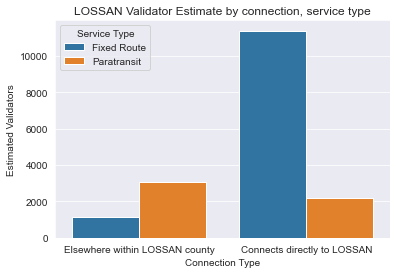

In [78]:
plt = sns.barplot(x='Connection Type', y='validator_count', hue='Service Type', data=grouped)
# plt.set_xlabel('Connects directly to LOSSAN')
plt.set_ylabel('Estimated Validators')
plt.set_title('LOSSAN Validator Estimate by connection, service type');

In [79]:
grouped

,validator_count,Service Type,Connection Type
0,1132.0,Fixed Route,Elsewhere within LOSSAN county
1,3070.0,Paratransit,Elsewhere within LOSSAN county
2,11377.0,Fixed Route,Connects directly to LOSSAN
3,2164.0,Paratransit,Connects directly to LOSSAN


In [80]:
grouped['validator_count'].sum() ## Estimate for all services, including paratransit

17743.0

In [81]:
grouped[grouped['Service Type'] == 'Fixed Route']['validator_count'].sum() ## Estimate not including paratransit

12509.0

## Map

* Operators connecting to LOSSAN in blue, others in orange. Use layer control on left to select one/both
* Note Ojai Trolley seems to overlap with other Ventura providers so it may be hard to view their individiual service areas/validators needed. Those metrics are however captured in the underlying data...

In [121]:
validators_by_operator = (lossan_corridor_operators
                              >> group_by(_.itp_id)
                              >> summarize(total_validators = _.validator_count.sum())
                         ).set_index('itp_id')

connecting_operator_stops = lossan_county_stops >> filter(_.itp_id.isin(lossan_connect_operators.itp_id))
non_connecting_operator_stops = lossan_county_stops >> filter(~_.itp_id.isin(lossan_connect_operators.itp_id))

In [125]:
def prep_stops(stops_gdf):
    to_map = stops_gdf.copy()
    to_map.geometry = to_map.to_crs('EPSG:6414').geometry.buffer(400)
    to_map = to_map.to_crs('EPSG:4326')[['itp_id','stop_name', 'geometry',
                                         'transit_provider', 'upt_total_2019']]
    to_map = to_map.dissolve(by='itp_id').join(validators_by_operator)
    return to_map

connecting_operator_stops = prep_stops(connecting_operator_stops)
non_connecting_operator_stops = prep_stops(non_connecting_operator_stops)

In [137]:
m = Map(basemap=basemaps.CartoDB.Positron, center=[34.28, -118.94], zoom=8)

html = HTML('''Hover to see provider, ridership info''')
html.layout.margin = '0px 20px 20px 20px'
control = WidgetControl(widget=html, position='topright')
m.add_control(control)

def update_html(feature,  **kwargs):
    html.value = '''
        <h3><b>{}</b></h3>
        <h4>2019 Ridership (UPT): {} </h4>
        <h4>Total Validators Needed: {}</h4>
    '''.format(feature['properties']['transit_provider'],
               feature['properties']['upt_total_2019'],
              feature['properties']['total_validators'])

geo_data_connecting = GeoData(geo_dataframe = connecting_operator_stops,
                       style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.3, 'weight':.5, 'dashArray':'2', 'fillOpacity':0.3},
                       hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                       name = 'Connecting Operator Stops')
geo_data_other = GeoData(geo_dataframe = non_connecting_operator_stops,
                       style={'color': 'black', 'fillColor': '#fec44f', 'opacity':0.3, 'weight':.5, 'dashArray':'2', 'fillOpacity':0.3},
                       hover_style={'fillColor': 'blue' , 'fillOpacity': 0.2},
                       name = 'Non-Connecting Operator Stops')

geo_data_connecting.on_hover(update_html)
geo_data_other.on_hover(update_html)

m.add_layer(geo_data_connecting)
m.add_layer(geo_data_other)
m.add_control(LayersControl())
m

Map(center=[34.28, -118.94], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…